# Exercise 10 - Linear FEM: rod with distributed load

Problem description:

First we introduce some general functionality and styles.

In [29]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
plt.style.use('seaborn-deep')
plt.rcParams['lines.linewidth']= 2.0
plt.rcParams['lines.color']= 'black'
plt.rcParams['legend.frameon']=True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['legend.fontsize']=14
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = (12, 6)

We first create an element class. An element knows the number of nodes it has, their IDs in the global node vector, and the coordinates of its nodes. Linear elements have 2 nodes and 2 quadrature points, quadratic elements 3 nodes and 3 quadrature points. The natural coordinates of the element run from -1 to 1, and the quadrature points and weights are directly taken from Numpy.

In [30]:
#element class
class line_element():#local coordinates go from -1 to 1
    #takes number of nodes, global nodal coordinates, global node ids
    def __init__(self, nnodes=2, ncoords=[0.,1.], nids=[0,1]):
        self.__nnodes = nnodes
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = (self.__coords-self.__coords[0])/(self.__coords[-1]-self.__coords[0])*2. - 1.
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = self.__nnodes
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
                

Next, we wish to generate a one-dimensional mesh by specifying the length of a line, the number of elements into which the mesh is to be split, and the number of nodes per element.

In [31]:
def number_of_nodes(nelems,nodes_per_elem):
    return nelems*nodes_per_elem - (nelems - 1)

def generate_mesh(domain_length,nelems,nodes_per_elem,pv_per_node):
    nn = number_of_nodes(nelems,nodes_per_elem)
    #coordinate vector of global nodes
    global_nodal_coordinates = np.linspace(0.,domain_length,nn)
    global_solution = np.array([[0.]*nn]*pv_per_node)
    
    #generate elements
    element_vector = []
    for i in range(nelems):
        node_start = (nodes_per_elem-1)*i
        element_vector.append(
            line_element(nodes_per_elem,
                         global_nodal_coordinates[node_start:node_start+nodes_per_elem],
                         list(range(node_start,node_start+nodes_per_elem))))
        
    return global_nodal_coordinates, element_vector, global_solution

Let's put this to test.

In [57]:
number_of_elements = 10
L = 10.
nodes_per_element = 3
number_of_primary_variables = 1

In [58]:
nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element,number_of_primary_variables)

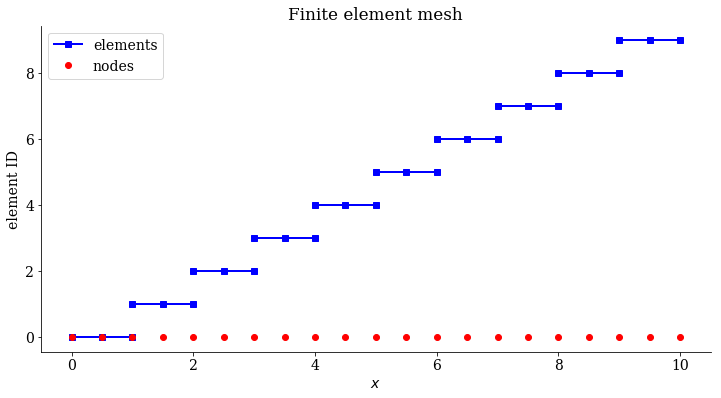

In [59]:
plt.xlabel('$x$')
plt.ylabel('element ID')
plt.title('Finite element mesh')
for i,elem in enumerate(elements):
    if (i==0):
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-', label='elements')
    else:
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-')
plt.plot(nodes, [0]*len(nodes), 'ro ', label='nodes')
plt.legend();

Now we have a mesh consisting of a vector of elements, and a global node vector. The next ingredient required are the shape functions for the elements in order to interpolate variables and determine gradients.

In [35]:
#N
def shape_function(element_order,xi):
    if (element_order == 2): #-1,1
            return np.array([(1.-xi)/2., (1.+xi)/2.])
    elif (element_order == 3): #-1, 0, 1
            return np.array([(xi - 1.)*xi/2., (1-xi)*(1+xi), (1+xi)*xi/2.])
#dN_dxi
def dshape_function_dxi(element_order,xi):
    if (element_order == 2): #-1,1
        return np.array([-0.5*xi/xi, 0.5*xi/xi])  #xi only later for plotting dimensions
    elif (element_order == 3):#-1,0,1
        return np.array([xi - 0.5,-2.*xi,xi + 0.5])

#dx_dxi
def element_jacobian(element,xi):
    element_order = element._line_element__nnodes
    Jacobian = 0.
    Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#dN_dx
def grad_shape_function(element,xi):
    element_order = element._line_element__nnodes
    Jac = element_jacobian(element,xi)
    return dshape_function_dxi(element_order,xi)/Jac


In [36]:
def plot_shape_functions(order):
    xi = np.linspace(-1.,1.,100)
    fig, ax = plt.subplots(ncols=2)
    ax[0].set_xlabel('$\\xi$')
    ax[0].set_ylabel('$N(\\xi)$')
    for i in range(order):
        ax[0].plot(xi,shape_function(order,xi)[i],label='$N_{%i}$' %i)
    ax[0].legend()
    ax[1].set_xlabel('$\\xi$')
    ax[1].set_ylabel('$\\mathrm{d}N(\\xi)/\\mathrm{d}\\xi$')
    for i in range(order):
        ax[1].plot(xi,dshape_function_dxi(order,xi)[i],label='$\\mathrm{d}N_{%i}/\\mathrm{d}\\xi$' %i)
    ax[1].legend()
    fig.tight_layout()

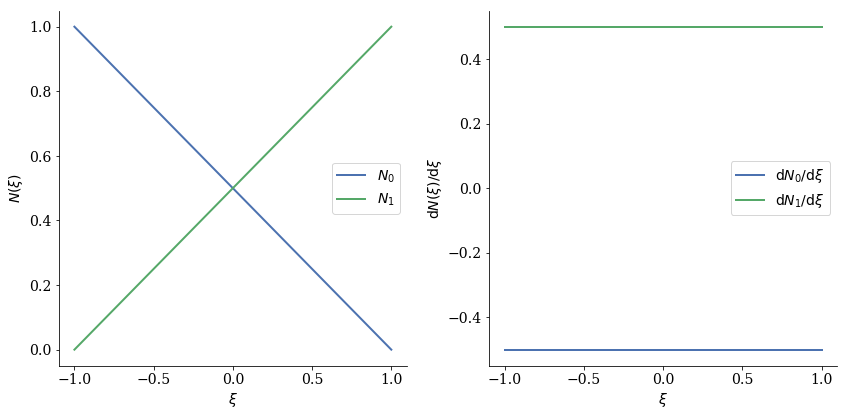

In [37]:
plot_shape_functions(2)

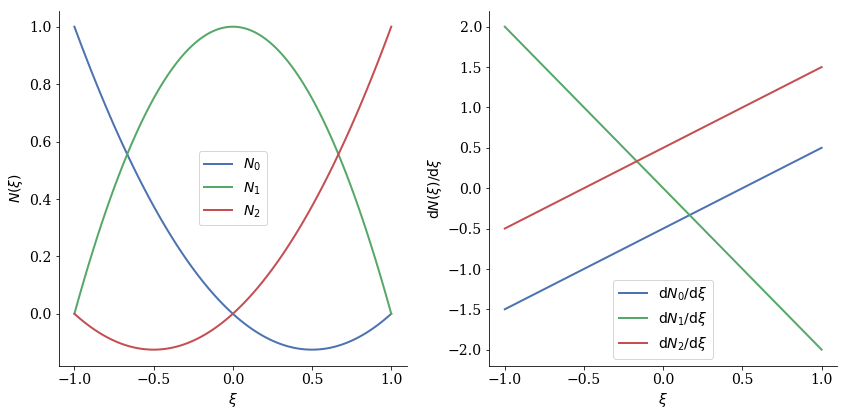

In [38]:
plot_shape_functions(3)

What we require now is the local assembler to calculate the stiffness matrix and the local right-hand side.

In [39]:
def CrossSection(x):
    A_0 = 0.01 #m²
    return A_0

def Stiffness(x):
    E0 = 210.e9 #Pa
    return E0

def Rigidity(x):#N
    return CrossSection(x)*Stiffness(x)

def Density(x):
    rho0 = 7600 #kg/m³
    return rho0

def BodyForce(x):#N/m
    g = 9.81
    return g*Density(x)*CrossSection(x)

In [40]:
def local_assembler(elem):
    element_order = elem._line_element__nnodes
    K_loc = np.zeros((element_order,element_order))
    b_loc = np.zeros(element_order)
    x_nodes = elem._line_element__coords
    for i in range(elem._line_element__quad_degree):
        #local integration point coordinate
        xi = elem._line_element__quad_points[i]
        #shape function
        N = shape_function(element_order,xi)
        #gradient of shape function
        dN_dX = grad_shape_function(elem,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem,xi))
        #integration weight
        w = elem._line_element__quad_weights[i]
        
        #global integration point coordinate
        x_glob = np.dot(N,x_nodes)
        #evaluation of local material/structural properties
        EA = Rigidity(x_glob)
        #evaluation of local body force
        rho_g_A = BodyForce(x_glob)
        
        #assembly of local stiffness matrix
        K_loc += np.outer(dN_dX,dN_dX) * EA * w * detJ
        
        #assembly of local RHS
        b_loc += N * rho_g_A * w * detJ
    return K_loc,b_loc

In [41]:
local_assembler(elements[3])

(array([[ 1.47e+10, -1.68e+10,  2.10e+09],
        [-1.68e+10,  3.36e+10, -1.68e+10],
        [ 2.10e+09, -1.68e+10,  1.47e+10]]), array([ 41.42, 165.68,  41.42]))

Now we can construct the global matrix system $\mathbf{K}\mathbf{u} = \mathbf{f}$ or $\mathbf{A}\mathbf{x}=\mathbf{b}$.

In [42]:
def global_assembler(nodes,elements,solution):
    K_glob = np.zeros((len(nodes),len(nodes)))
    b_glob = np.zeros(len(nodes))
    for i,elem in enumerate(elements):
        K_i, b_i = local_assembler(elem)
        start_id = elem._line_element__global_ids[0]
        end_id = elem._line_element__global_ids[-1]
        K_glob[start_id:end_id+1,start_id:end_id+1] += K_i
        b_glob[start_id:end_id+1] += b_i
    return K_glob, b_glob

In [43]:
def apply_Neumann_bc(b_glob,node_id,value):
    b_glob[node_id] += value
    return b_glob

In [44]:
def apply_Dirichlet_bc(K_glob,b_glob,node_id,value):
    K_glob[node_id,:] = K_glob[:,node_id] = 0.
    K_glob[node_id,node_id] = 1.
    b_glob[node_id] = value
    return K_glob, b_glob

In [45]:
K, f = global_assembler(nodes,elements,solution)

In [46]:
f = apply_Neumann_bc(f,len(nodes)-1,0)

In [47]:
K, f = apply_Dirichlet_bc(K, f, 0, 0.)

In [48]:
solution = np.linalg.solve(K,f)

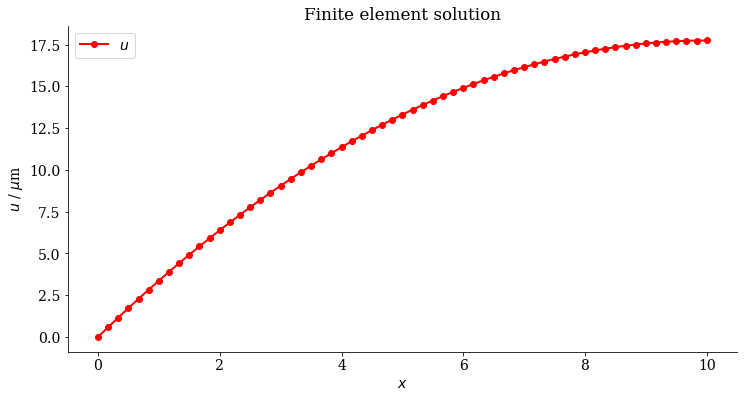

In [49]:
plt.xlabel('$x$')
plt.ylabel('$u$ / $\\mu$m')
plt.title('Finite element solution')
plt.plot(nodes, solution*1e6, 'ro-', label='$u$')
plt.legend();

Let's do a simple convergence study.

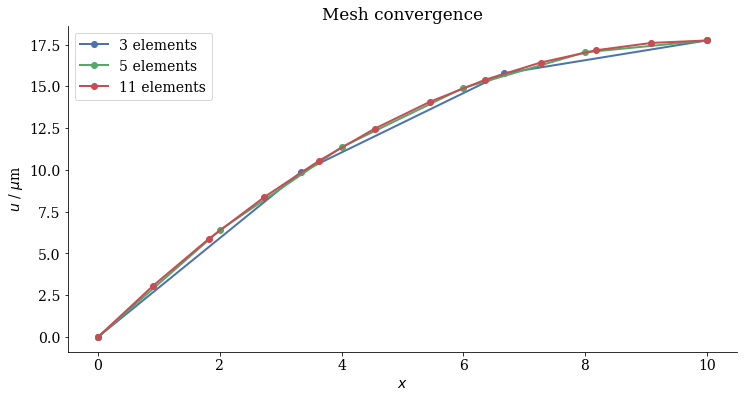

In [50]:
plt.xlabel('$x$')
plt.ylabel('$u$ / $\\mu$m')
plt.title('Mesh convergence')
for i in [3,5,11]:
    number_of_elements = i
    nodes_per_element = 2
    nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element,number_of_primary_variables)
    K, f = global_assembler(nodes,elements,solution)
    f = apply_Neumann_bc(f,len(nodes)-1,0)
    K, f = apply_Dirichlet_bc(K, f, 0, 0.)
    solution = np.linalg.solve(K,f)
    plt.plot(nodes, solution*1e6, marker = 'o', label='%i elements' %i)
plt.legend();

That's quite boring. Let's make the case a little bit more interesting, by giving the cross section a variation and applying a compressive force at the free end.

In [51]:
CrossSection = lambda x: 0.01+0.008*np.sin(x)
F_c = -3.e3 #N

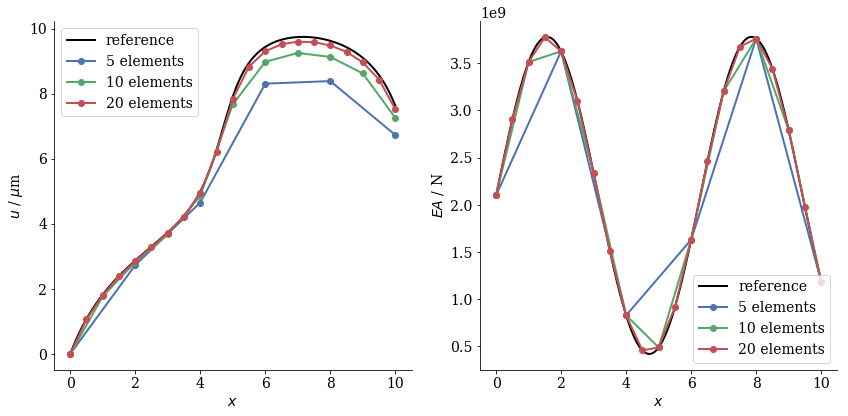

In [52]:
fig, ax = plt.subplots(ncols=2)
ax[0].set_xlabel('$x$')
ax[1].set_xlabel('$x$')
ax[0].set_ylabel('$u$ / $\\mu$m')
ax[1].set_ylabel('$EA$ / N')#$\\mu$m$^2$')
nodes_per_element = 2
finest = 1000
for i in [finest,5,10,20]:
    number_of_elements = i
    nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element,number_of_primary_variables)
    K, f = global_assembler(nodes,elements,solution)
    f = apply_Neumann_bc(f,len(nodes)-1,F_c)
    K, f = apply_Dirichlet_bc(K, f, 0, 0.)
    solution = np.linalg.solve(K,f)
    if (i == finest):
        ax[1].plot(nodes, Rigidity(nodes), label='reference',color='black')
        ax[0].plot(nodes, solution*1e6, label='reference',color='black')
    else:
        ax[1].plot(nodes, Rigidity(nodes), marker = 'o', label='%i elements' %i)
        ax[0].plot(nodes, solution*1e6, marker = 'o', label='%i elements' %i)
ax[0].legend();
ax[1].legend();
fig.tight_layout()

Something similar can be done to demonstrate the effect of higher-order elements.

In [53]:
def run_sim(npe,ne):
    nodes,elements,solution=generate_mesh(L,ne,npe,number_of_primary_variables)
    K, f = global_assembler(nodes,elements,solution)
    f = apply_Neumann_bc(f,len(nodes)-1,F_c)
    K, f = apply_Dirichlet_bc(K, f, 0, 0.)
    solution = np.linalg.solve(K,f)
    return nodes, solution

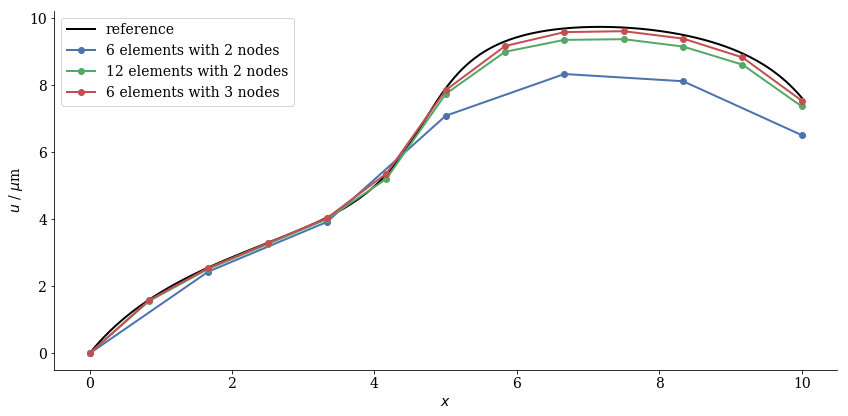

In [54]:
fig, ax = plt.subplots()
ax.set_xlabel('$x$')
ax.set_ylabel('$u$ / $\\mu$m')
#reference
nodes, solution = run_sim(2,1000)
ax.plot(nodes, solution*1e6, label='reference',color='black')
#10 linear elements
nodes, solution = run_sim(2,6)
ax.plot(nodes, solution*1e6, label='6 elements with 2 nodes',marker='o')
#20 linear elements
nodes, solution = run_sim(2,12)
ax.plot(nodes, solution*1e6, label='12 elements with 2 nodes',marker='o')
#10 quadratic elements
nodes, solution = run_sim(3,6)
ax.plot(nodes, solution*1e6, label='6 elements with 3 nodes',marker='o')

ax.legend();
fig.tight_layout()

We see that with the same number of nodes, the higher-order approximation is better.

In [55]:
from ipywidgets import widgets
from ipywidgets import interact

# Compute reference solution with 100 cells
nodes_ref, solution_ref = run_sim(2,1000)

@interact(num_cells=widgets.IntSlider(min=1, max=20, value=5, description='cells'),
         npes=widgets.RadioButtons(options=[2,3], value=2, description='element order',))
def plot(num_cells=5,npes=2):
    plt.xlabel('$x$')
    plt.ylabel('$u$ / $\\mu$m')
    x, u = run_sim(npes,num_cells)
    plt.plot(nodes_ref, solution_ref*1e6, '--', color='k', label='reference solution');
    plt.plot(x, u*1e6, 'o-', label=str(len(x)) + ' nodes');
    plt.legend(loc='upper left');

interactive(children=(IntSlider(value=5, description='cells', max=20, min=1), RadioButtons(description='elemen…

In [56]:
@interact(num_nodes=widgets.IntSlider(min=3, max=41, value=5, step=2, description='nodes'),
         npes=widgets.RadioButtons(options=[2,3], value=2, description='element order',))
def plot(num_nodes=5,npes=2):
    plt.xlabel('$x$')
    plt.ylabel('$u$ / $\\mu$m')
    num_cells = int((num_nodes - 1)/(npes - 1))
    x, u = run_sim(npes,num_cells)
    plt.plot(nodes_ref, solution_ref*1e6, '--', color='k', label='reference solution');
    plt.plot(x, u*1e6, 'o-', label=str(num_cells) + ' elements');
    plt.legend(loc='upper left');

interactive(children=(IntSlider(value=5, description='nodes', max=41, min=3, step=2), RadioButtons(description…